# Введение в анализ данных (первый семестр)
## Домашнее задание №3 - Участие в конкурсе Rossmann Store Sales

<b>Дедлайн сдачи домашнего задания: 27 апреля, 22:00. После дедлайна решения не принимаются.</b><br>
<br>
В данном домашнем задании вам придется учавствовать в конкурсе [Rossman Store Sales](https://www.kaggle.com/c/rossmann-store-sales). Ваша задача получить наиболее высокий результат на Private Leaderboard, используя только те методы, которые вы узнали до сегодняшнего дня на курсах Техносферы. Оценка домашнего задания будет производиться через kaggle kernels. До дедлайна вам необходимо прислать на почту письмо с ссылкой на ваш kernel. Не забудьте указать правильно тему:)

<h2>Подготовка</h2>

Импорт всех необходимых пакетов:

In [91]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

Описание всех необходимых функций, используемых далее:

In [102]:
def to_weight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = to_weight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

In [2]:
def str_date_to_ordinal(date):
    return datetime.strptime(date, '%Y-%m-%d').date().toordinal()

def date_to_ordinal(date):
    return date.toordinal()

def str_to_date(date):
    return datetime.strptime(date, '%Y-%m-%d').date()

In [66]:
SEED = 42

<h2>Загрузка и предобработка данных</h2>

<h3>1) Загрузка тренировочных и тестовых данных</h3>

In [3]:
train_df = pd.read_csv('./data/train.csv', sep=',', parse_dates=['Date'], date_parser=str_to_date,
                      low_memory=False)
test_df = pd.read_csv('./data/test.csv', sep=',', parse_dates=['Date'], date_parser=str_to_date,
                      low_memory=False)

In [4]:
print "Train data head:"
train_df.head()

Train data head:


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
print "Test data head:"
test_df.head()

Test data head:


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


<h3>2) Обработка пропущенных значений в тренировочных и тестовых данных</h3>

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null datetime64[ns]
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


Как видно из информации о тренировочной выборке, пропущенных значений в ней нет.

In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null datetime64[ns]
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 2.5+ MB


Как видно из информации о тестовой выборке, пропущенных значений в ней нет нигде, кроме 11 пропущенных значений переменной $Open$.

In [8]:
test_df[pd.isnull(test_df.Open)]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0


Видно, что все 11 пропущенных значений относятся к магазину 622. Предположим, что магазин был открыт ($Open$ == 1), т.к. если окажется, что магазин был закрыт, то мы предскажем $Sales$ = 0, и это никак не повлияет на ошибку в предсказании. В случае же, если магазин был на самом деле открыт, а мы предположили, что он закрыт и автоматически предсказали 0, мы получим ошибку.

In [9]:
test_df.loc[pd.isnull(test_df.Open), 'Open'] = 1

<h3>3) Векторизация категориальных признаков в тренировочных и тестовых данных</h3>

Объединим выборки в одну для анализа значений категориальных переменных. Заметим, что в тестовой выборке есть переменная $Id$, не принимающая NaN значений, а в тренировочной выборке данной переменной нет. Поэтому по значению Nan или non-NaN данной переменной будем различать тренировочную и тестовую выборки.

In [10]:
all_df = pd.concat([train_df, test_df], axis=0)
all_df.head()

,Customers,Date,DayOfWeek,Id,Open,Promo,Sales,SchoolHoliday,StateHoliday,Store
0,555.0,2015-07-31,5,NaN,1.0,1,5263.0,1,0,1
1,625.0,2015-07-31,5,NaN,1.0,1,6064.0,1,0,2
2,821.0,2015-07-31,5,NaN,1.0,1,8314.0,1,0,3
3,1498.0,2015-07-31,5,NaN,1.0,1,13995.0,1,0,4
4,559.0,2015-07-31,5,NaN,1.0,1,4822.0,1,0,5


In [11]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1058297 entries, 0 to 41087
Data columns (total 10 columns):
Customers        1017209 non-null float64
Date             1058297 non-null datetime64[ns]
DayOfWeek        1058297 non-null int64
Id               41088 non-null float64
Open             1058297 non-null float64
Promo            1058297 non-null int64
Sales            1017209 non-null float64
SchoolHoliday    1058297 non-null int64
StateHoliday     1058297 non-null object
Store            1058297 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(4), object(1)
memory usage: 88.8+ MB


Векторизуем с помощью OneHotEncoder категориальные признаки: $StateHoliday$

In [12]:
unique_StateHoliday_values = np.sort(all_df.StateHoliday.unique())
print "Train data StateHoliday unique values:", np.sort(train_df.StateHoliday.unique())
print "Test data StateHoliday unique values: ", np.sort(test_df.StateHoliday.unique())
print "All data StateHoliday unique values:  ", unique_StateHoliday_values

Train data StateHoliday unique values: ['0' 'a' 'b' 'c']
Test data StateHoliday unique values:  ['0' 'a']
All data StateHoliday unique values:   ['0' 'a' 'b' 'c']


Как видно, в тестовых данных отсутствуют категории 'b' и 'c'.

Пронумеруем все уникальные значения переменной $StateHoliday$: 

In [13]:
all_df['StateHoliday'] = all_df['StateHoliday'].astype('category').cat.codes

Выполним векторизацию:

In [14]:
StateHoliday_columns_names = ["StateHoliday_%c" % c for c in unique_StateHoliday_values]
StateHoliday_columns = OneHotEncoder(sparse=False).fit_transform(all_df.StateHoliday.reshape(-1,1))
all_df = pd.concat([all_df, pd.DataFrame(StateHoliday_columns, columns=StateHoliday_columns_names, 
                                         index=all_df.index)],
                   axis=1)
all_df.head()

,Customers,Date,DayOfWeek,Id,Open,Promo,Sales,SchoolHoliday,StateHoliday,Store,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c
0,555.0,2015-07-31,5,NaN,1.0,1,5263.0,1,0,1,1.0,0.0,0.0,0.0
1,625.0,2015-07-31,5,NaN,1.0,1,6064.0,1,0,2,1.0,0.0,0.0,0.0
2,821.0,2015-07-31,5,NaN,1.0,1,8314.0,1,0,3,1.0,0.0,0.0,0.0
3,1498.0,2015-07-31,5,NaN,1.0,1,13995.0,1,0,4,1.0,0.0,0.0,0.0
4,559.0,2015-07-31,5,NaN,1.0,1,4822.0,1,0,5,1.0,0.0,0.0,0.0


In [15]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1058297 entries, 0 to 41087
Data columns (total 14 columns):
Customers         1017209 non-null float64
Date              1058297 non-null datetime64[ns]
DayOfWeek         1058297 non-null int64
Id                41088 non-null float64
Open              1058297 non-null float64
Promo             1058297 non-null int64
Sales             1017209 non-null float64
SchoolHoliday     1058297 non-null int64
StateHoliday      1058297 non-null int8
Store             1058297 non-null int64
StateHoliday_0    1058297 non-null float64
StateHoliday_a    1058297 non-null float64
StateHoliday_b    1058297 non-null float64
StateHoliday_c    1058297 non-null float64
dtypes: datetime64[ns](1), float64(8), int64(4), int8(1)
memory usage: 114.0 MB


Преобразуем переменную $Date$. Для того, чтобы выяснить, как дата влияет на продажи, построим график зависимости целевой переменной от даты.<br>
Первым делом, предположим, что существует зависимость продаж от периодов: день месяца, неделя года, месяц года, год, день года. Саму же переменную $Date$ преобразуем с помощью datetime.toordinal для численной интерпретации.

Проанализируем непрерывность временного диапазона в тренировочной и тестовой выборках:

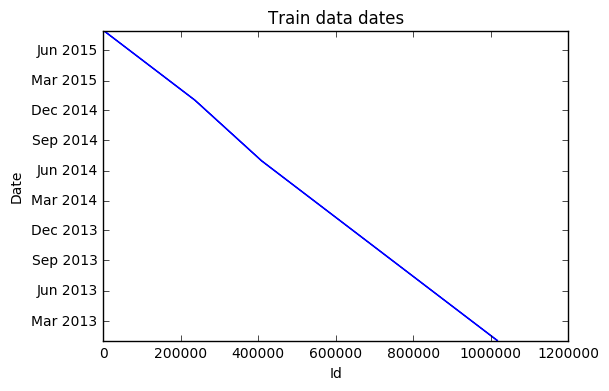

In [16]:
plt.xlabel("Id")
plt.ylabel("Date")
plt.plot(train_df.index, train_df.Date)
plt.title("Train data dates")
plt.show()

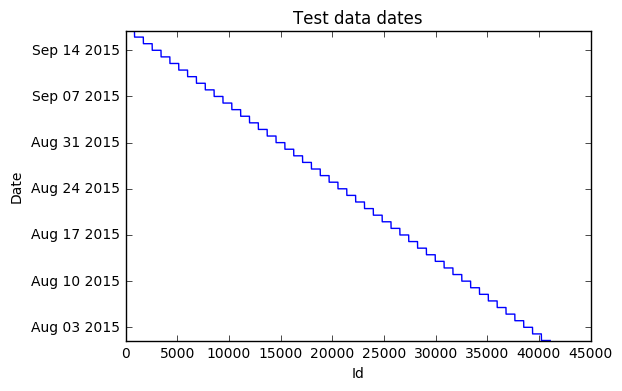

In [17]:
plt.xlabel("Id")
plt.ylabel("Date")
plt.plot(test_df.index, test_df.Date)
plt.title("Test data dates")
plt.show()

In [18]:
feature_name = 'Date'
dispatcher = {'Day': pd.Index(all_df[feature_name]).day, 
              'Week': pd.Index(all_df[feature_name]).week,
              'Month': pd.Index(all_df[feature_name]).month,
              'Year': pd.Index(all_df[feature_name]).year,
              'DayOfYear': pd.Index(all_df[feature_name]).dayofyear}

for new_feat_suffx, mapping in dispatcher.iteritems():
    all_df[feature_name + new_feat_suffx] = mapping

all_df[feature_name] = all_df[feature_name].apply(date_to_ordinal)

all_df.head()

,Customers,Date,DayOfWeek,Id,Open,Promo,Sales,SchoolHoliday,StateHoliday,Store,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,DateWeek,DateDayOfYear,DateYear,DateDay,DateMonth
0,555.0,735810,5,NaN,1.0,1,5263.0,1,0,1,1.0,0.0,0.0,0.0,31,212,2015,31,7
1,625.0,735810,5,NaN,1.0,1,6064.0,1,0,2,1.0,0.0,0.0,0.0,31,212,2015,31,7
2,821.0,735810,5,NaN,1.0,1,8314.0,1,0,3,1.0,0.0,0.0,0.0,31,212,2015,31,7
3,1498.0,735810,5,NaN,1.0,1,13995.0,1,0,4,1.0,0.0,0.0,0.0,31,212,2015,31,7
4,559.0,735810,5,NaN,1.0,1,4822.0,1,0,5,1.0,0.0,0.0,0.0,31,212,2015,31,7


In [19]:
all_df.columns

Index([u'Customers', u'Date', u'DayOfWeek', u'Id', u'Open', u'Promo', u'Sales',
       u'SchoolHoliday', u'StateHoliday', u'Store', u'StateHoliday_0',
       u'StateHoliday_a', u'StateHoliday_b', u'StateHoliday_c', u'DateWeek',
       u'DateDayOfYear', u'DateYear', u'DateDay', u'DateMonth'],
      dtype='object')

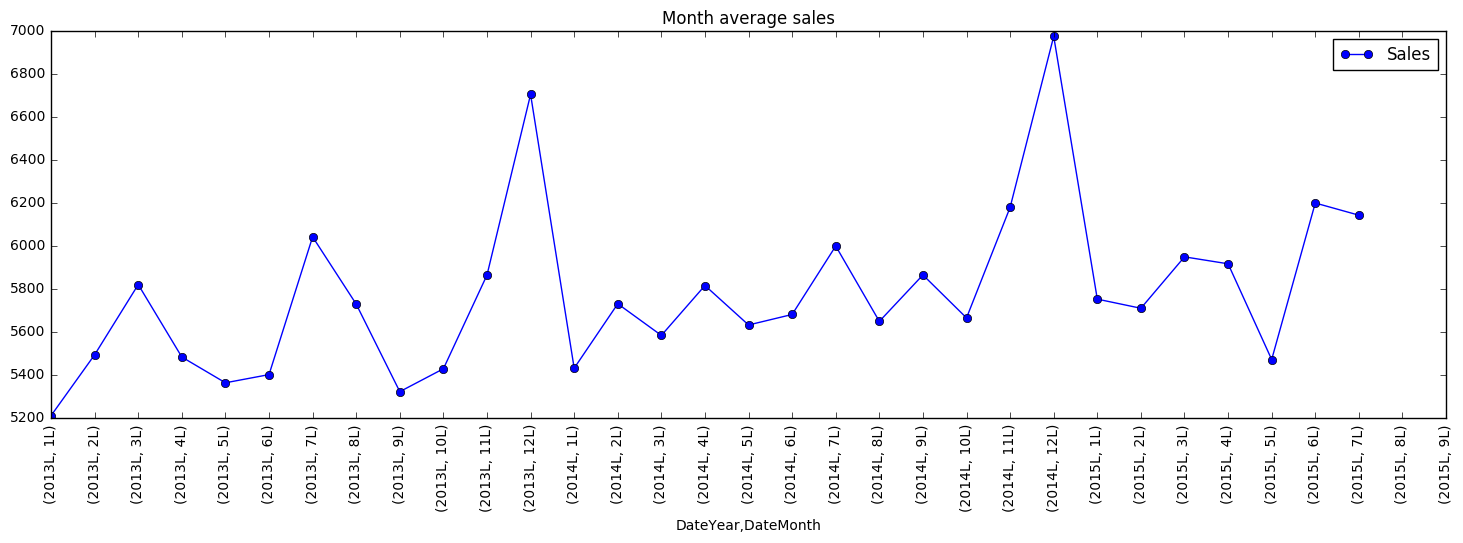

In [20]:
# group by date and get average sales, and precent change
grouped_by_month = all_df.groupby(['DateYear', 'DateMonth'])["Sales"]
grouped_by_month_and_week = all_df.groupby(['DateYear', 'DateMonth', 'DateWeek'])["Sales"]
average_sales_month = grouped_by_month.mean()
average_sales_month_and_week = grouped_by_month_and_week.mean()

# plot average sales over time(year-month)
plt1 = average_sales_month.plot(legend=True, marker='o', title="Month average sales", figsize=(18,5))
plt1.set_xticks(range(len(average_sales_month)))
plt1.set_xticklabels(average_sales_month.index.tolist(), rotation=90)
print ""

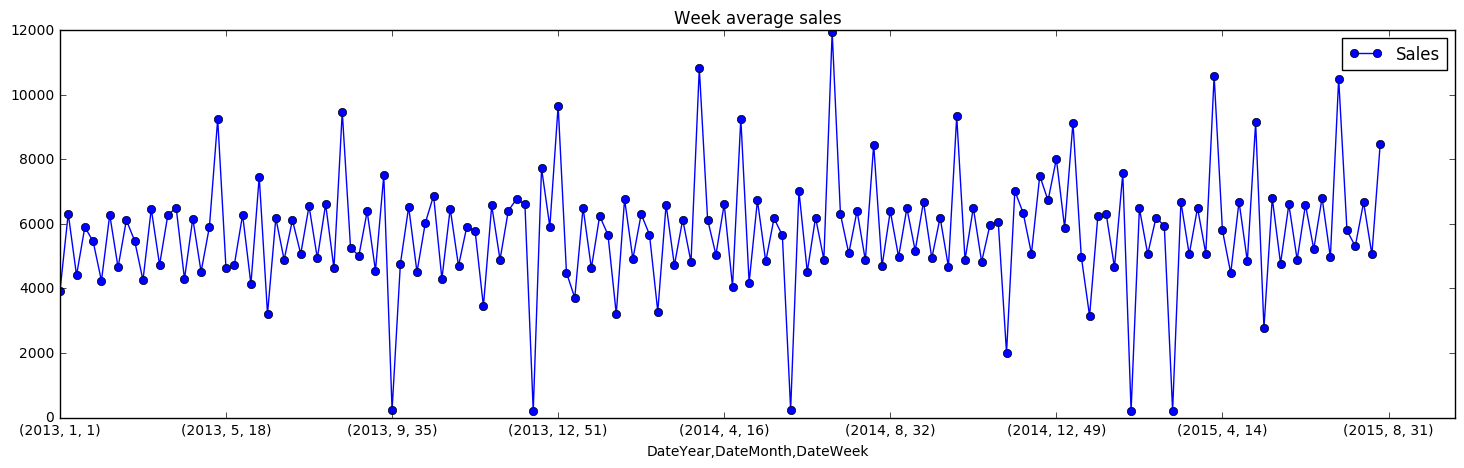

In [21]:
# plot precent change for sales over time(year-month)
plt2 = average_sales_month_and_week.plot(legend=True, marker='o', title="Week average sales", 
                                         figsize=(18,5))

<h3>4) Удаление ненужных признаков из тренировочных и тестовых данных</h3>

Выберем для удаления признаки, кторые больше не нужны в выборках:

In [22]:
columns_to_drop = ['StateHoliday']

Добавим линейно зависимые признаки в список признаков для удаления:

In [23]:
columns_to_drop.append('StateHoliday_0')

Удалим выбранные признаки:

In [24]:
all_df.drop(columns_to_drop, axis=1, inplace=True)
all_df.head()

,Customers,Date,DayOfWeek,Id,Open,Promo,Sales,SchoolHoliday,Store,StateHoliday_a,StateHoliday_b,StateHoliday_c,DateWeek,DateDayOfYear,DateYear,DateDay,DateMonth
0,555.0,735810,5,NaN,1.0,1,5263.0,1,1,0.0,0.0,0.0,31,212,2015,31,7
1,625.0,735810,5,NaN,1.0,1,6064.0,1,2,0.0,0.0,0.0,31,212,2015,31,7
2,821.0,735810,5,NaN,1.0,1,8314.0,1,3,0.0,0.0,0.0,31,212,2015,31,7
3,1498.0,735810,5,NaN,1.0,1,13995.0,1,4,0.0,0.0,0.0,31,212,2015,31,7
4,559.0,735810,5,NaN,1.0,1,4822.0,1,5,0.0,0.0,0.0,31,212,2015,31,7


<h3>5) Загрузка данных о магазинах</h3>

In [25]:
store_df = pd.read_csv('./data/store.csv', sep=',')
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [26]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


<h3>6) Векторизация категориальных признаков в данных о магазинах</h3>

Категориальные признаки - $StoreType$ и $Assortment$. Также обработаем все временные признаки.

In [27]:
unique_StoreType_values =np.sort(store_df['StoreType'].unique())
unique_Assortment_values = np.sort(store_df['Assortment'].unique())
print "Unique values of StoreType: ", unique_StoreType_values
print "Unique values of Assortment:", unique_Assortment_values

Unique values of StoreType:  ['a' 'b' 'c' 'd']
Unique values of Assortment: ['a' 'b' 'c']


In [28]:
store_df['StoreType'] = store_df['StoreType'].astype('category').cat.codes
store_df['Assortment'] = store_df['Assortment'].astype('category').cat.codes
print "Unique values of StoreType: ", np.sort(store_df['StoreType'].unique())
print "Unique values of Assortment:", np.sort(store_df['Assortment'].unique())

Unique values of StoreType:  [0 1 2 3]
Unique values of Assortment: [0 1 2]


In [29]:
StoreType_columns_names = ["StoreType_%c" % c for c in unique_StoreType_values]
StoreType_columns = OneHotEncoder(sparse=False).fit_transform(store_df.StoreType.reshape(-1,1))
store_df = pd.concat([store_df, pd.DataFrame(StoreType_columns, columns=StoreType_columns_names, 
                                         index=store_df.index)],
                   axis=1)

Assortment_columns_names = ["Assortment_%c" % c for c in unique_Assortment_values]
Assortment_columns = OneHotEncoder(sparse=False).fit_transform(store_df.Assortment.reshape(-1,1))
store_df = pd.concat([store_df, pd.DataFrame(Assortment_columns, columns=Assortment_columns_names, 
                                         index=store_df.index)],
                   axis=1)

store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,1,2,0,1270.0,9.0,2008.0,0,NaN,NaN,NaN,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,2,0,0,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4,2,2,620.0,9.0,2009.0,0,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,5,0,0,29910.0,4.0,2015.0,0,NaN,NaN,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0


Далее необходимо преобразовать переменные $CompetitionOpenSinceYear$ и $CompetitionOpenSinceMonth$ к числовому представлению, чтобы можно было сравнивать для каждой из покупок, была ли она совершена в данный период, или нет.

In [30]:
def CompetitionOpenSince_to_ordinal(row):
    try:
        date = '%d-%d' % (int(row['CompetitionOpenSinceYear']), int(row['CompetitionOpenSinceMonth']))
        return datetime.strptime(date, '%Y-%m').date().toordinal()
    except:
        return np.nan

In [31]:
store_df['CompetitionOpenSinceDate'] = store_df.apply(CompetitionOpenSince_to_ordinal, axis=1)
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,CompetitionOpenSinceDate
0,1,2,0,1270.0,9.0,2008.0,0,NaN,NaN,NaN,0.0,0.0,1.0,0.0,1.0,0.0,0.0,733286.0
1,2,0,0,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",1.0,0.0,0.0,0.0,1.0,0.0,0.0,732981.0
2,3,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",1.0,0.0,0.0,0.0,1.0,0.0,0.0,732646.0
3,4,2,2,620.0,9.0,2009.0,0,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,1.0,733651.0
4,5,0,0,29910.0,4.0,2015.0,0,NaN,NaN,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0,735689.0


Теперь необходимо преобразовать переменные $Promo2SinceYear$ и $Promo2SinceWeek$ числовому представлению, чтобы можно было сравнивать для каждой из покупок, была ли она совершена в данный период, или нет. Для этого введём переменную $Promo2SinceDate$. Если $Promo2SinceYear$ и $Promo2SinceWeek$ заданы для магазина, то $Promo2SinceDate$ = date($Promo2SinceYear$, $Promo2SinceWeek$).toordinal(), иначе  $Promo2SinceDate$ = 0 (т.к. для магазинов с $Promo2$ == 0 интервалы участия в промо-акции не заданы (что логично), и т.к. для магазинов с $Promo2$ == 1 и неопределёнными сроками участия в промо-акции подразумевается, что акции проводятся во все года существования магазина)

In [32]:
def Promo2Since_to_ordinal(row):
    try:
        date = '%d-%d' % (int(row['Promo2SinceYear']), int(row['Promo2SinceWeek']))
        return datetime.strptime(date, '%Y-%m').date().toordinal()
    except:
        return 0

In [33]:
store_df['Promo2SinceDate'] = store_df.apply(Promo2Since_to_ordinal, axis=1)
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,CompetitionOpenSinceDate,Promo2SinceDate
0,1,2,0,1270.0,9.0,2008.0,0,NaN,NaN,NaN,0.0,0.0,1.0,0.0,1.0,0.0,0.0,733286.0,0
1,2,0,0,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",1.0,0.0,0.0,0.0,1.0,0.0,0.0,732981.0,0
2,3,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",1.0,0.0,0.0,0.0,1.0,0.0,0.0,732646.0,0
3,4,2,2,620.0,9.0,2009.0,0,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,1.0,733651.0,0
4,5,0,0,29910.0,4.0,2015.0,0,NaN,NaN,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0,735689.0,0


И, наконец, необходимо преобразовать переменную $PromoInterval$: посчитаем возможные её значения, и разделим её на то количество переменных, сколько месяцев перечислено в интервалах.

In [34]:
store_df['PromoInterval'].unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'], dtype=object)

Видно, что либо сезонные промо-акции магазина проводятся 4 раза в год (либо в конце времени года, либо в середине, либо в начале), либо сезонных акций нет. Отсюда следует, что для однозначного определения сроков сезонной акции достаточно одного месяца. Пусть первый месяц интервалов определяет тип сезонности акций: 1, 2 или 3 будет означать Jan, Feb или Mar. Создадим переменную, которая будет хранить тип сезонности акции, или 0, если $PromoInterval$ == NaN, и векторизуем её.

In [35]:
promo2_intervals = pd.DataFrame(store_df['PromoInterval'].str.split(',').apply(pd.Series, 1).iloc[:,0], 
                                index=store_df.index, columns=['PromoIntervalType'])
store_df = pd.concat([store_df, promo2_intervals], axis=1)
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,CompetitionOpenSinceDate,Promo2SinceDate,PromoIntervalType
0,1,2,0,1270.0,9.0,2008.0,0,NaN,NaN,NaN,0.0,0.0,1.0,0.0,1.0,0.0,0.0,733286.0,0,NaN
1,2,0,0,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",1.0,0.0,0.0,0.0,1.0,0.0,0.0,732981.0,0,Jan
2,3,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",1.0,0.0,0.0,0.0,1.0,0.0,0.0,732646.0,0,Jan
3,4,2,2,620.0,9.0,2009.0,0,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,1.0,733651.0,0,NaN
4,5,0,0,29910.0,4.0,2015.0,0,NaN,NaN,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0,735689.0,0,NaN


In [36]:
def month_to_num(month):
    if pd.isnull(month):
        return 0
    return {'Jan' : 2, 'Feb' : 3, 'Mar' : 1}[month]

In [37]:
store_df['PromoIntervalType'] = store_df['PromoIntervalType'].apply(month_to_num)
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,CompetitionOpenSinceDate,Promo2SinceDate,PromoIntervalType
0,1,2,0,1270.0,9.0,2008.0,0,NaN,NaN,NaN,0.0,0.0,1.0,0.0,1.0,0.0,0.0,733286.0,0,0
1,2,0,0,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",1.0,0.0,0.0,0.0,1.0,0.0,0.0,732981.0,0,2
2,3,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",1.0,0.0,0.0,0.0,1.0,0.0,0.0,732646.0,0,2
3,4,2,2,620.0,9.0,2009.0,0,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,1.0,733651.0,0,0
4,5,0,0,29910.0,4.0,2015.0,0,NaN,NaN,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0,735689.0,0,0


In [38]:
unique_PromoIntervalType_values = np.sort(store_df['PromoIntervalType'].unique())
PromoIntervalType_columns_names = ["PromoIntervalType_%d" % n for n in unique_PromoIntervalType_values]
PromoIntervalType_columns = OneHotEncoder(sparse=False).fit_transform(store_df.PromoIntervalType.reshape(-1,1))
store_df = pd.concat([store_df, pd.DataFrame(PromoIntervalType_columns, columns=PromoIntervalType_columns_names, 
                                         index=store_df.index)],
                   axis=1)

store_df.head().T

,0,1,2,3,4
Store,1,2,3,4,5
StoreType,2,0,0,2,0
Assortment,0,0,0,2,0
CompetitionDistance,1270,570,14130,620,29910
CompetitionOpenSinceMonth,9,11,12,9,4
CompetitionOpenSinceYear,2008,2007,2006,2009,2015
Promo2,0,1,1,0,0
Promo2SinceWeek,NaN,13,14,NaN,NaN
Promo2SinceYear,NaN,2010,2011,NaN,NaN
PromoInterval,NaN,"Jan,Apr,Jul,Oct","Jan,Apr,Jul,Oct",NaN,NaN


<h3>7) Удаление ненужных признаков из данных о магазинах</h3>

Выберем переменные, которые можно удалить из датасета с информацией о магазинах из-за ненадобности:

In [39]:
columns_to_drop = ['StoreType', 'Assortment', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
                   'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'PromoIntervalType']

Выберем для удаления линейно зависимые переменные из датасета с информацией о магазинах:<br>
1) $Promo2$ и $PromoIntervalType\_0$ линейно зависимы, т.к. $PromoIntervalType\_0$ == 1 тогда и только тогда, когда $Promo2$ == 0<br>
2) $PromoIntervalType\_3$ зависит от $Promo2$, $PromoIntervalType\_1$ и $PromoIntervalType\_2$<br>
3) $Assortment\_c$ зависит от $Assortment\_a$ и $Assortment\_b$<br>
4) $StoreType\_d$ зависит от $StoreType\_a$, $StoreType\_b$ и $StoreType\_c$<br>

In [40]:
columns_to_drop.append('PromoIntervalType_0')
columns_to_drop.append('PromoIntervalType_3')
columns_to_drop.append('Assortment_c')
columns_to_drop.append('StoreType_d')

Удалим все выбранные столбцы из датасета с информацией о магазинах:

In [41]:
store_df.drop(columns_to_drop, axis=1, inplace=True)
store_df.head()

,Store,CompetitionDistance,Promo2,StoreType_a,StoreType_b,StoreType_c,Assortment_a,Assortment_b,CompetitionOpenSinceDate,Promo2SinceDate,PromoIntervalType_1,PromoIntervalType_2
0,1,1270.0,0,0.0,0.0,1.0,1.0,0.0,733286.0,0,0.0,0.0
1,2,570.0,1,1.0,0.0,0.0,1.0,0.0,732981.0,0,0.0,1.0
2,3,14130.0,1,1.0,0.0,0.0,1.0,0.0,732646.0,0,0.0,1.0
3,4,620.0,0,0.0,0.0,1.0,0.0,0.0,733651.0,0,0.0,0.0
4,5,29910.0,0,1.0,0.0,0.0,1.0,0.0,735689.0,0,0.0,0.0


<h3>8) Обработка пропущенных значений в данных о магазинах</h3>

Во время обработки категориальных и временных признаков мы обработали часть пропущенных значений. Обработаем оставшиеся пропущенные значения в получившейся выборке.

In [42]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 12 columns):
Store                       1115 non-null int64
CompetitionDistance         1112 non-null float64
Promo2                      1115 non-null int64
StoreType_a                 1115 non-null float64
StoreType_b                 1115 non-null float64
StoreType_c                 1115 non-null float64
Assortment_a                1115 non-null float64
Assortment_b                1115 non-null float64
CompetitionOpenSinceDate    761 non-null float64
Promo2SinceDate             1115 non-null int64
PromoIntervalType_1         1115 non-null float64
PromoIntervalType_2         1115 non-null float64
dtypes: float64(9), int64(3)
memory usage: 104.6 KB


In [43]:
nan_columns = store_df.columns[store_df.isnull().any()].tolist()
for column in nan_columns:
    store_df[column] = store_df[column].fillna(-1)

In [44]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 12 columns):
Store                       1115 non-null int64
CompetitionDistance         1115 non-null float64
Promo2                      1115 non-null int64
StoreType_a                 1115 non-null float64
StoreType_b                 1115 non-null float64
StoreType_c                 1115 non-null float64
Assortment_a                1115 non-null float64
Assortment_b                1115 non-null float64
CompetitionOpenSinceDate    1115 non-null float64
Promo2SinceDate             1115 non-null int64
PromoIntervalType_1         1115 non-null float64
PromoIntervalType_2         1115 non-null float64
dtypes: float64(9), int64(3)
memory usage: 104.6 KB


<h3>9) Слияние данных о продажах и о магазинах</h3>

In [45]:
df = pd.merge(all_df, store_df, how='left', on=['Store'])
df.head().T

,0,1,2,3,4
Customers,555.0,625.0,821.0,1498.0,559.0
Date,735810.0,735810.0,735810.0,735810.0,735810.0
DayOfWeek,5.0,5.0,5.0,5.0,5.0
Id,NaN,NaN,NaN,NaN,NaN
Open,1.0,1.0,1.0,1.0,1.0
Promo,1.0,1.0,1.0,1.0,1.0
Sales,5263.0,6064.0,8314.0,13995.0,4822.0
SchoolHoliday,1.0,1.0,1.0,1.0,1.0
Store,1.0,2.0,3.0,4.0,5.0
StateHoliday_a,0.0,0.0,0.0,0.0,0.0


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1058297 entries, 0 to 1058296
Data columns (total 28 columns):
Customers                   1017209 non-null float64
Date                        1058297 non-null int64
DayOfWeek                   1058297 non-null int64
Id                          41088 non-null float64
Open                        1058297 non-null float64
Promo                       1058297 non-null int64
Sales                       1017209 non-null float64
SchoolHoliday               1058297 non-null int64
Store                       1058297 non-null int64
StateHoliday_a              1058297 non-null float64
StateHoliday_b              1058297 non-null float64
StateHoliday_c              1058297 non-null float64
DateWeek                    1058297 non-null int32
DateDayOfYear               1058297 non-null int32
DateYear                    1058297 non-null int32
DateDay                     1058297 non-null int32
DateMonth                   1058297 non-null int32
Competit

<h2>Применение линейной регрессии для предсказания продаж</h2>

In [52]:
train_df = all_df[all_df['Id'].isnull()].drop(['Id'], axis=1)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 16 columns):
Customers         1017209 non-null float64
Date              1017209 non-null int64
DayOfWeek         1017209 non-null int64
Open              1017209 non-null float64
Promo             1017209 non-null int64
Sales             1017209 non-null float64
SchoolHoliday     1017209 non-null int64
Store             1017209 non-null int64
StateHoliday_a    1017209 non-null float64
StateHoliday_b    1017209 non-null float64
StateHoliday_c    1017209 non-null float64
DateWeek          1017209 non-null int32
DateDayOfYear     1017209 non-null int32
DateYear          1017209 non-null int32
DateDay           1017209 non-null int32
DateMonth         1017209 non-null int32
dtypes: float64(6), int32(5), int64(5)
memory usage: 112.5 MB


In [53]:
test_df = all_df[all_df['Id'].notnull()].drop(['Sales', 'Customers'], axis=1)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 15 columns):
Date              41088 non-null int64
DayOfWeek         41088 non-null int64
Id                41088 non-null float64
Open              41088 non-null float64
Promo             41088 non-null int64
SchoolHoliday     41088 non-null int64
Store             41088 non-null int64
StateHoliday_a    41088 non-null float64
StateHoliday_b    41088 non-null float64
StateHoliday_c    41088 non-null float64
DateWeek          41088 non-null int32
DateDayOfYear     41088 non-null int32
DateYear          41088 non-null int32
DateDay           41088 non-null int32
DateMonth         41088 non-null int32
dtypes: float64(5), int32(5), int64(5)
memory usage: 4.2 MB


In [61]:
X_train = train_df[train_df.columns.drop(['Customers', 'Sales'])].values
y_train = train_df['Sales'].values
print X_train.shape, y_train.shape

(1017209L, 14L) (1017209L,)


In [63]:
X_test = test_df[test_df.columns.drop(['Id'])].values
X_test.shape

(41088L, 14L)

In [105]:
X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train, y_train,
                                                                           train_size=0.08,
                                                                           test_size=0.02,
                                                                           random_state=SEED)
print X_train_train.shape, X_train_test.shape, y_train_train.shape, y_train_test.shape

(81376L, 14L) (20345L, 14L) (81376L,) (20345L,)


In [106]:
X_train_train = StandardScaler().fit_transform(X_train_train)
X_train_test = StandardScaler().fit_transform(X_train_test)

In [107]:
regr = SGDRegressor(random_state=SEED, alpha=0.1)
regr.fit(X_train_train, y_train_train)

SGDRegressor(alpha=0.1, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=42, shuffle=True, verbose=0, warm_start=False)

In [108]:
print rmspe(regr.predict(X_train_test), y_train_test)

0.473964102691


In [109]:
svr = SVR(C=1.0, kernel='rbf')
svr.fit(X_train_train, y_train_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [110]:
print rmspe(svr.predict(X_train_test), y_train_test)

0.397058065093
